<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/CustomFittingOnLowerLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# **DATA LOAD**

In [18]:
def get_mnist_model():
  inputs = keras.Input(shape=(28 * 28,))
  features = layers.Dense(512, activation='relu')(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation='softmax')(features)

  model = keras.Model(inputs, outputs)
  return model


(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60_000, 28 * 28)).astype('float32') / 255.0
test_images = test_images.reshape((10_000, 28 * 28)).astype('float32') / 255.0

train_images, val_images = images[10_000:], images[:10_000]
train_labels, val_labels = labels[10_000:], labels[:10_000]


In [19]:
model = get_mnist_model()

In [20]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

In [21]:
@tf.function
def train_step(inputs, targets):
  # forward propagation
  with tf.GradientTape() as tape:
    predictions = model(inputs, training=True)
    loss = loss_fn(targets, predictions)
  # backpropagation
  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # getting logs (metrics and loss)
  logs = {}
  for metric in metrics:
    metric.update_state(targets, predictions)
    logs[metric.name] = metric.result()

  loss_tracking_metric.update_state(loss)
  logs['loss'] = loss_tracking_metric.result()
  return logs

In [22]:
# we strictly must reset metrics as it's logical (cmon, think about it, it's logical)
def reset_metrics():
  for metric in metrics:
    metric.reset_state()
  loss_tracking_metric.reset_state()

In [23]:
# data preparation
#   1. batches split
#   2. dataset forming
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)
)

training_dataset = training_dataset.batch(32)
epochs = 3

for epoch in range(epochs):
  reset_metrics()
  for inputs_batch, targets_batch in training_dataset:
    logs = train_step(inputs_batch, targets_batch)
  print(f'results at the end of {epoch} epoch')
  for key, value in logs.items():
    print(f'...{key}: {value}')

results at the end of 0 epoch
...sparse_categorical_accuracy: 0.913919985294342
...loss: 0.2888200283050537
results at the end of 1 epoch
...sparse_categorical_accuracy: 0.9531999826431274
...loss: 0.15876807272434235
results at the end of 2 epoch
...sparse_categorical_accuracy: 0.9638599753379822
...loss: 0.1278458535671234


# **YEAH... We reinvented the bicycle**

In [24]:
# Now let's evaluate our model

In [31]:
@tf.function
def test_step(inputs, targets):
  with tf.GradientTape() as tape:
    # here we set training arg to false, as we're not training now
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  logs = {}
  for metric in metrics:
    metric.update_state(targets, predictions)
    logs[metric.name] = metric.result()

  loss_tracking_metric.update_state(loss)
  logs['loss'] = loss_tracking_metric.result()
  return logs, predictions

In [32]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
  logs, pred = test_step(inputs_batch, targets_batch)
print('Evaluation results: ')
for key, value in logs.items():
  print(f'...{key}: {value:.4f}')

Evaluation results: 
...sparse_categorical_accuracy: 0.9851
...loss: 0.0554


In [40]:
train_images[0].shape

(784,)

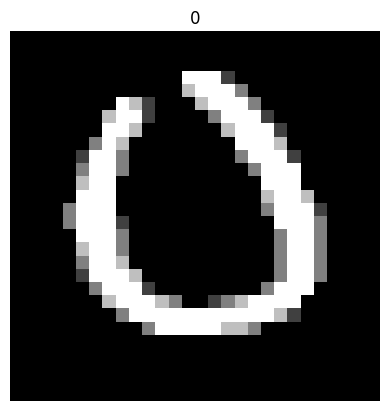

In [52]:
plt.title(str(np.argmax(pred[10])))
plt.axis('off')
plt.imshow(train_images[10].reshape(28, 28), cmap='gray');

# **I CAN TOUCH BONES OF KERAS**

In [27]:
# the funniest thing here, is @tf.function decorator. This 1 short line speeds up and optimizes our functions